In [1]:
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import jax
import cv2
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

import tensorflow as tf

tf.config.set_visible_devices([], "GPU")

import jax.numpy as jnp
from absl import app, flags
import optax
import json
import numpy as np
from functools import partial
import orbax.checkpoint as ocp
from tensorflow_text import SentencepieceTokenizer
# from palivla.dataset import prepare_image
from palivla.tokenizer import Tokenizer
from palivla.load_model import load_model_params_decode
from scalax.sharding import MeshShardingHelper, FSDPShardingRule, PartitionSpec
from flax.training.train_state import TrainState
from jax.experimental import multihost_utils
from ml_collections import config_flags
from palivla.train_state import PaliVLATrainState
from palivla.types import TrainingBatch, RolloutBatch

# export TPU_VISIBLE_DEVICES=0 
# export TPU_CHIPS_PER_HOST_BOUNDS=1,1,1 
# export TPU_HOST_BOUNDS=1,1,1 
# export TPU_MESH_CONTROLLER_ADDRESS=localhost:8476 
# export TPU_MESH_CONTROLLER_PORT=8476

os.environ['TPU_VISIBLE_DEVICES'] = '0'
os.environ['TPU_CHIPS_PER_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_MESH_CONTROLLER_ADDRESS'] = 'localhost:8476'
os.environ['TPU_MESH_CONTROLLER_PORT'] = '8476'


/nfs/nfs2/users/mitsuhiko/miniconda/envs/big_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-29 23:25:22.020330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732922722.038825 2086939 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732922722.044378 2086939 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 23:25:25.130567: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call 

## Load Datasets
Next, we will load a trajectory from the bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [12]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ind = np.random.randint(0, 1000)
ds = builder.as_dataset(split=f'train[{ind}:{ind+1}]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (224, 224)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

Instruction: close cabinet


In [3]:


# action_mean = np.array(dataset_statistics[dataset_name]["action"]["mean"])
# action_std = np.array(dataset_statistics[dataset_name]["action"]["std"])
# action_mask = np.array(dataset_statistics[dataset_name]["action"]["mask"])
def make_inference_batch(batch):
    sensors = {
        k: batch["observation"][k][None].numpy()
        for k in batch["observation"]
        if k in model.model_state.model.modality_mappings and k != "text"
    }
    sensors_mask = {
        k: batch["observation"]["pad_mask_dict"][k].numpy()
        for k in model.model_state.model.modality_mappings
        if k != "text"
    }
    return RolloutBatch(
            sensor_data=sensors,
            sensor_masks=sensors_mask,
            prompt=batch["tokens"][None].numpy(),
            prompt_mask=batch["mask_input"][None].numpy(),
            prompt_ar=np.zeros_like(batch["mask_ar"][None]),
        )
    

# Do inference
def do_inference(images, instructions):
    data = {
        "observation": {"image_primary": images, "pad_mask_dict": {"image_primary": tf.ones(len(images), dtype=tf.bool)}},
        "task": {"language_instruction": instructions},
    }
    language_token_instructions = tokenizer.tokenize_language_instruction(data)
    # batch = prepare_image(batch)
    batch = tokenizer.prepare_tokens_for_generation(data, language_token_instructions)
    batch = batch | data
    rollout_batch = make_inference_batch(batch)

    out_tokens, value = decode(
        rollout_batch, None
    )
    out_tokens = jax.device_get(multihost_utils.process_allgather(out_tokens))
    value = jax.device_get(multihost_utils.process_allgather(value))
    decoded_actions = tokenizer.detokenize_action(out_tokens)

    # Re-normalize actions using dataset statistics
    # decoded_actions = decoded_actions * action_std + action_mean
    # decoded_actions = unnormalize_action(decoded_actions, dataset_statistics[dataset_name]["action"])
    decoded_actions = unnormalize_action_minmax(decoded_actions, dataset_statistics[dataset_name]["action"])

    return decoded_actions, value

def unnormalize_action(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action * unnormalization_statistics["std"])
        + unnormalization_statistics["mean"],
        action,
    )
    return action

def unnormalize_action_minmax(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action + 1) / 2 * (unnormalization_statistics["p99"] - unnormalization_statistics["p01"]) + unnormalization_statistics["p01"],
        action,
    )

    return action

In [15]:
resume_from_checkpoint_dir = "gs://rail-tpus-mitsuhiko-central2/logs/test/visionary-fire-42/"
# resume_from_checkpoint_step = "gs://rail-tpus-mitsuhiko-central2/logs/test/bright-thunder-2/"
resume_from_checkpoint_step = 100000
dataset_name = "bridge_dataset"

In [16]:
# Sharding
mesh = MeshShardingHelper([-1], ["fsdp"])

model_sharding = FSDPShardingRule("fsdp", fsdp_axis_size=mesh.mesh.shape["fsdp"])
data_sharding = PartitionSpec("fsdp")
# data_sharding = jax.sharding.SingleDeviceSharding(jax.local_devices()[0])

restore_checkpoint_manager = ocp.CheckpointManager(
        resume_from_checkpoint_dir,
        item_handlers=PaliVLATrainState.get_checkpoint_handlers(),
)

model = PaliVLATrainState.restore(
        checkpoint_manager=restore_checkpoint_manager,
        step=resume_from_checkpoint_step,
        load_optimizer=False,
        mesh=mesh,
        model_sharding=model_sharding,
        data_sharding=data_sharding,
    )
tokenizer = model.tokenizer
decode = model.decode
dataset_statistics = model.dataset_statistics


In [17]:
tokenizer

Tokenizer(config=Tokenizer.TokenizerConfig(action_vocab_size=256, action_vocab_offset=256000, vocab_size=<bound method SentencepieceTokenizer.vocab_size of <tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7f3d6c12ffa0>>, num_action_tokens=7, bos_token=2, eos_token=1, pad_token=0, begin_of_action_token=108, end_of_action_token=3, max_pad_length=60, min_action_value=-2, max_action_value=2, prompt_autoregressive=False), language_tokenizer=<tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7f3d6c12ffa0>, token_structure=FrozenDict({
    causal: ('action', (3,)),
    pad: ((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),),
    prefix: ((2,), 'prompt', (108,)),
}), action_tokenizer=BinActionTokenizer(
    # attributes
    min_action_value = -2
    max_action_value = 2
    action_dim = 7
 

## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both, goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [18]:
WINDOW_SIZE = 1
# run inference loop, this model only uses single image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
pred_values = []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_image = images[step][None]
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1.0
    instruction = tf.constant(language_instruction)
    
    actions, value = do_inference(input_image, instruction)
    print(value, actions)
    pred_actions.append(actions)
    pred_values.append(value)

    true_actions.append(np.concatenate(
        (
            steps[step]['action']['world_vector'], 
            steps[step]['action']['rotation_delta'], 
            np.array(steps[step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))

  0%|          | 0/31 [00:00<?, ?it/s]

0 [[256128]]
0 -17.663446
1 [[256128]]
1 -18.236706
2 [[256114]]
2 -17.29891
3 [[256127]]
3 -22.510258
4 [[256134]]
4 -18.331959
5 [[256128]]
5 -11.953299
6 [[256192]]
6 -9.206401
7 [[3]]
7 -11.84855


  3%|▎         | 1/31 [00:00<00:08,  3.61it/s]

[array(-17.663446, dtype=float32), array(-18.236706, dtype=float32), array(-17.29891, dtype=float32), array(-22.510258, dtype=float32), array(-18.331959, dtype=float32), array(-11.953299, dtype=float32), array(-9.206401, dtype=float32), array(-11.84855, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -17.66261
1 [[256128]]
1 -18.233034
2 [[256114]]
2 -17.290518
3 [[256127]]
3 -22.539263
4 [[256134]]
4 -18.275885
5 [[256128]]
5 -11.95296
6 [[256192]]
6 -9.204877
7 [[3]]


  6%|▋         | 2/31 [00:00<00:07,  4.04it/s]

7 -11.841234
[array(-17.66261, dtype=float32), array(-18.233034, dtype=float32), array(-17.290518, dtype=float32), array(-22.539263, dtype=float32), array(-18.275885, dtype=float32), array(-11.95296, dtype=float32), array(-9.204877, dtype=float32), array(-11.841234, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -17.662437
1 [[256128]]
1 -18.232655
2 [[256114]]
2 -17.29194
3 [[256127]]
3 -22.531998
4 [[256134]]
4 -18.32152
5 [[256128]]
5 -11.954572
6 [[256192]]


 10%|▉         | 3/31 [00:00<00:06,  4.22it/s]

6 -9.2045355
7 [[3]]
7 -11.836551
[array(-17.662437, dtype=float32), array(-18.232655, dtype=float32), array(-17.29194, dtype=float32), array(-22.531998, dtype=float32), array(-18.32152, dtype=float32), array(-11.954572, dtype=float32), array(-9.2045355, dtype=float32), array(-11.836551, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -17.658258
1 [[256128]]
1 -18.208479
2 [[256114]]
2 -17.275213
3 [[256127]]
3 -22.62302
4 [[256134]]
4 -18.426765
5 [[256128]]


 13%|█▎        | 4/31 [00:00<00:06,  4.30it/s]

5 -11.93564
6 [[256192]]
6 -9.190872
7 [[3]]
7 -11.776423
[array(-17.658258, dtype=float32), array(-18.208479, dtype=float32), array(-17.275213, dtype=float32), array(-22.62302, dtype=float32), array(-18.426765, dtype=float32), array(-11.93564, dtype=float32), array(-9.190872, dtype=float32), array(-11.776423, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -17.650295
1 [[256128]]
1 -18.212275
2 [[256114]]
2 -17.26696
3 [[256127]]
3 -22.663479
4 [[256134]]


 16%|█▌        | 5/31 [00:01<00:05,  4.36it/s]

4 -18.308552
5 [[256128]]
5 -11.928171
6 [[256192]]
6 -9.189208
7 [[3]]
7 -11.646899
[array(-17.650295, dtype=float32), array(-18.212275, dtype=float32), array(-17.26696, dtype=float32), array(-22.663479, dtype=float32), array(-18.308552, dtype=float32), array(-11.928171, dtype=float32), array(-9.189208, dtype=float32), array(-11.646899, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -17.656254
1 [[256128]]
1 -18.219967
2 [[256114]]
2 -17.265278
3 [[256127]]


 19%|█▉        | 6/31 [00:01<00:05,  4.38it/s]

3 -22.68666
4 [[256134]]
4 -17.793638
5 [[256128]]
5 -11.929443
6 [[256192]]
6 -9.196227
7 [[3]]
7 -11.511195
[array(-17.656254, dtype=float32), array(-18.219967, dtype=float32), array(-17.265278, dtype=float32), array(-22.68666, dtype=float32), array(-17.793638, dtype=float32), array(-11.929443, dtype=float32), array(-9.196227, dtype=float32), array(-11.511195, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -17.699526
1 [[256128]]
1 -18.275936
2 [[256114]]


 23%|██▎       | 7/31 [00:01<00:05,  4.40it/s]

2 -17.270638
3 [[256127]]
3 -22.805288
4 [[256134]]
4 -17.826267
5 [[256128]]
5 -11.932953
6 [[256192]]
6 -9.192562
7 [[3]]
7 -11.518479
[array(-17.699526, dtype=float32), array(-18.275936, dtype=float32), array(-17.270638, dtype=float32), array(-22.805288, dtype=float32), array(-17.826267, dtype=float32), array(-11.932953, dtype=float32), array(-9.192562, dtype=float32), array(-11.518479, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]
0 -17.661741
1 [[256128]]


 26%|██▌       | 8/31 [00:01<00:05,  4.42it/s]

1 -18.22505
2 [[256114]]
2 -17.277584
3 [[256127]]
3 -22.603146
4 [[256134]]
4 -17.75341
5 [[256128]]
5 -11.941177
6 [[256192]]
6 -9.199003
7 [[3]]
7 -11.573721
[array(-17.661741, dtype=float32), array(-18.22505, dtype=float32), array(-17.277584, dtype=float32), array(-22.603146, dtype=float32), array(-17.75341, dtype=float32), array(-11.941177, dtype=float32), array(-9.199003, dtype=float32), array(-11.573721, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]
0 [[256128]]


 29%|██▉       | 9/31 [00:02<00:04,  4.42it/s]

0 -17.659277
1 [[256128]]
1 -18.220308
2 [[256114]]
2 -17.277042
3 [[256127]]
3 -22.585133
4 [[256134]]
4 -17.938269
5 [[256128]]
5 -11.942673
6 [[256192]]
6 -9.198445
7 [[3]]
7 -11.617306
[array(-17.659277, dtype=float32), array(-18.220308, dtype=float32), array(-17.277042, dtype=float32), array(-22.585133, dtype=float32), array(-17.938269, dtype=float32), array(-11.942673, dtype=float32), array(-9.198445, dtype=float32), array(-11.617306, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 32%|███▏      | 10/31 [00:02<00:04,  4.42it/s]

0 [[256128]]
0 -17.659874
1 [[256128]]
1 -18.22103
2 [[256114]]
2 -17.280304
3 [[256127]]
3 -22.586035
4 [[256134]]
4 -17.870737
5 [[256128]]
5 -11.940284
6 [[256192]]
6 -9.199843
7 [[3]]
7 -11.64047
[array(-17.659874, dtype=float32), array(-18.22103, dtype=float32), array(-17.280304, dtype=float32), array(-22.586035, dtype=float32), array(-17.870737, dtype=float32), array(-11.940284, dtype=float32), array(-9.199843, dtype=float32), array(-11.64047, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 35%|███▌      | 11/31 [00:02<00:04,  4.43it/s]

0 [[256128]]
0 -17.655914
1 [[256128]]
1 -18.228634
2 [[256114]]
2 -17.288393
3 [[256127]]
3 -22.555834
4 [[256134]]
4 -18.080736
5 [[256128]]
5 -11.950811
6 [[256192]]
6 -9.201087
7 [[3]]
7 -11.839899
[array(-17.655914, dtype=float32), array(-18.228634, dtype=float32), array(-17.288393, dtype=float32), array(-22.555834, dtype=float32), array(-18.080736, dtype=float32), array(-11.950811, dtype=float32), array(-9.201087, dtype=float32), array(-11.839899, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 39%|███▊      | 12/31 [00:02<00:04,  4.43it/s]

0 [[256128]]
0 -17.698034
1 [[256128]]
1 -18.284134
2 [[256114]]
2 -17.296576
3 [[256127]]
3 -22.54132
4 [[256134]]
4 -17.625973
5 [[256128]]
5 -11.958396
6 [[256192]]
6 -9.206035
7 [[3]]
7 -11.287704
[array(-17.698034, dtype=float32), array(-18.284134, dtype=float32), array(-17.296576, dtype=float32), array(-22.54132, dtype=float32), array(-17.625973, dtype=float32), array(-11.958396, dtype=float32), array(-9.206035, dtype=float32), array(-11.287704, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 42%|████▏     | 13/31 [00:02<00:04,  4.44it/s]

0 [[256128]]
0 -17.675383
1 [[256128]]
1 -18.247425
2 [[256114]]
2 -17.2928
3 [[256127]]
3 -22.516682
4 [[256134]]
4 -17.580734
5 [[256128]]
5 -11.963127
6 [[256192]]
6 -9.209448
7 [[3]]
7 -11.276159
[array(-17.675383, dtype=float32), array(-18.247425, dtype=float32), array(-17.2928, dtype=float32), array(-22.516682, dtype=float32), array(-17.580734, dtype=float32), array(-11.963127, dtype=float32), array(-9.209448, dtype=float32), array(-11.276159, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 45%|████▌     | 14/31 [00:03<00:03,  4.44it/s]

0 [[256128]]
0 -17.635368
1 [[256128]]
1 -18.217518
2 [[256114]]
2 -17.275747
3 [[256127]]
3 -22.482014
4 [[256134]]
4 -17.673735
5 [[256128]]
5 -11.9639845
6 [[256192]]
6 -9.217042
7 [[3]]
7 -11.273416
[array(-17.635368, dtype=float32), array(-18.217518, dtype=float32), array(-17.275747, dtype=float32), array(-22.482014, dtype=float32), array(-17.673735, dtype=float32), array(-11.9639845, dtype=float32), array(-9.217042, dtype=float32), array(-11.273416, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 48%|████▊     | 15/31 [00:03<00:03,  4.45it/s]

0 [[256128]]
0 -17.64591
1 [[256128]]
1 -18.211483
2 [[256114]]
2 -17.286842
3 [[256127]]
3 -22.486603
4 [[256134]]
4 -17.674124
5 [[256128]]
5 -11.963777
6 [[256192]]
6 -9.212025
7 [[3]]
7 -11.017856
[array(-17.64591, dtype=float32), array(-18.211483, dtype=float32), array(-17.286842, dtype=float32), array(-22.486603, dtype=float32), array(-17.674124, dtype=float32), array(-11.963777, dtype=float32), array(-9.212025, dtype=float32), array(-11.017856, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 52%|█████▏    | 16/31 [00:03<00:03,  4.45it/s]

0 [[256128]]
0 -17.674068
1 [[256128]]
1 -18.233898
2 [[256114]]
2 -17.293776
3 [[256127]]
3 -22.51071
4 [[256134]]
4 -17.625505
5 [[256128]]
5 -11.964744
6 [[256192]]
6 -9.209135
7 [[3]]
7 -11.032257
[array(-17.674068, dtype=float32), array(-18.233898, dtype=float32), array(-17.293776, dtype=float32), array(-22.51071, dtype=float32), array(-17.625505, dtype=float32), array(-11.964744, dtype=float32), array(-9.209135, dtype=float32), array(-11.032257, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 55%|█████▍    | 17/31 [00:03<00:03,  4.44it/s]

0 [[256128]]
0 -17.647017
1 [[256128]]
1 -18.21046
2 [[256114]]
2 -17.264254
3 [[256127]]
3 -22.68184
4 [[256134]]
4 -17.942242
5 [[256128]]
5 -11.931362
6 [[256192]]
6 -9.188002
7 [[3]]
7 -11.632942
[array(-17.647017, dtype=float32), array(-18.21046, dtype=float32), array(-17.264254, dtype=float32), array(-22.68184, dtype=float32), array(-17.942242, dtype=float32), array(-11.931362, dtype=float32), array(-9.188002, dtype=float32), array(-11.632942, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 58%|█████▊    | 18/31 [00:04<00:02,  4.44it/s]

0 [[256128]]
0 -17.682455
1 [[256128]]
1 -18.264744
2 [[256114]]
2 -17.26648
3 [[256127]]
3 -22.806416
4 [[256134]]
4 -17.845266
5 [[256128]]
5 -11.935177
6 [[256192]]
6 -9.182141
7 [[3]]
7 -11.463866
[array(-17.682455, dtype=float32), array(-18.264744, dtype=float32), array(-17.26648, dtype=float32), array(-22.806416, dtype=float32), array(-17.845266, dtype=float32), array(-11.935177, dtype=float32), array(-9.182141, dtype=float32), array(-11.463866, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 61%|██████▏   | 19/31 [00:04<00:02,  4.44it/s]

0 [[256128]]
0 -17.690205
1 [[256128]]
1 -18.270142
2 [[256114]]
2 -17.28439
3 [[256127]]
3 -22.771687
4 [[256134]]
4 -17.801588
5 [[256128]]
5 -11.937662
6 [[256192]]
6 -9.184682
7 [[3]]
7 -11.410065
[array(-17.690205, dtype=float32), array(-18.270142, dtype=float32), array(-17.28439, dtype=float32), array(-22.771687, dtype=float32), array(-17.801588, dtype=float32), array(-11.937662, dtype=float32), array(-9.184682, dtype=float32), array(-11.410065, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 65%|██████▍   | 20/31 [00:04<00:02,  4.44it/s]

0 [[256128]]
0 -17.668304
1 [[256128]]
1 -18.241436
2 [[256114]]
2 -17.283419
3 [[256127]]
3 -22.694622
4 [[256134]]
4 -17.829096
5 [[256128]]
5 -11.937085
6 [[256192]]
6 -9.183144
7 [[3]]
7 -11.414815
[array(-17.668304, dtype=float32), array(-18.241436, dtype=float32), array(-17.283419, dtype=float32), array(-22.694622, dtype=float32), array(-17.829096, dtype=float32), array(-11.937085, dtype=float32), array(-9.183144, dtype=float32), array(-11.414815, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 68%|██████▊   | 21/31 [00:04<00:02,  4.45it/s]

0 [[256128]]
0 -17.684698
1 [[256128]]
1 -18.303766
2 [[256114]]
2 -17.345823
3 [[256127]]
3 -22.579424
4 [[256134]]
4 -17.67155
5 [[256128]]
5 -11.949756
6 [[256192]]
6 -9.210201
7 [[3]]
7 -11.502487
[array(-17.684698, dtype=float32), array(-18.303766, dtype=float32), array(-17.345823, dtype=float32), array(-22.579424, dtype=float32), array(-17.67155, dtype=float32), array(-11.949756, dtype=float32), array(-9.210201, dtype=float32), array(-11.502487, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 71%|███████   | 22/31 [00:05<00:02,  4.45it/s]

0 [[256128]]
0 -17.660872
1 [[256128]]
1 -18.235573
2 [[256114]]
2 -17.289928
3 [[256127]]
3 -22.557621
4 [[256134]]
4 -17.643171
5 [[256128]]
5 -11.952517
6 [[256192]]
6 -9.207468
7 [[3]]
7 -11.703134
[array(-17.660872, dtype=float32), array(-18.235573, dtype=float32), array(-17.289928, dtype=float32), array(-22.557621, dtype=float32), array(-17.643171, dtype=float32), array(-11.952517, dtype=float32), array(-9.207468, dtype=float32), array(-11.703134, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 74%|███████▍  | 23/31 [00:05<00:01,  4.44it/s]

0 [[256128]]
0 -17.691751
1 [[256128]]
1 -18.224823
2 [[256114]]
2 -17.293678
3 [[256127]]
3 -22.541927
4 [[256134]]
4 -18.07871
5 [[256128]]
5 -11.944223
6 [[256192]]
6 -9.206257
7 [[3]]
7 -11.27984
[array(-17.691751, dtype=float32), array(-18.224823, dtype=float32), array(-17.293678, dtype=float32), array(-22.541927, dtype=float32), array(-18.07871, dtype=float32), array(-11.944223, dtype=float32), array(-9.206257, dtype=float32), array(-11.27984, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 77%|███████▋  | 24/31 [00:05<00:01,  4.44it/s]

0 [[256128]]
0 -17.693775
1 [[256128]]
1 -18.254742
2 [[256114]]
2 -17.299967
3 [[256127]]
3 -22.513668
4 [[256134]]
4 -17.598362
5 [[256128]]
5 -11.960363
6 [[256192]]
6 -9.16964
7 [[3]]
7 -11.266342
[array(-17.693775, dtype=float32), array(-18.254742, dtype=float32), array(-17.299967, dtype=float32), array(-22.513668, dtype=float32), array(-17.598362, dtype=float32), array(-11.960363, dtype=float32), array(-9.16964, dtype=float32), array(-11.266342, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 81%|████████  | 25/31 [00:05<00:01,  4.44it/s]

0 [[256128]]
0 -17.658756
1 [[256128]]
1 -18.224588
2 [[256114]]
2 -17.293901
3 [[256127]]
3 -22.464848
4 [[256134]]
4 -17.673965
5 [[256128]]
5 -11.969137
6 [[256192]]
6 -9.177256
7 [[3]]
7 -10.897856
[array(-17.658756, dtype=float32), array(-18.224588, dtype=float32), array(-17.293901, dtype=float32), array(-22.464848, dtype=float32), array(-17.673965, dtype=float32), array(-11.969137, dtype=float32), array(-9.177256, dtype=float32), array(-10.897856, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 84%|████████▍ | 26/31 [00:05<00:01,  4.44it/s]

0 [[256128]]
0 -17.664997
1 [[256128]]
1 -18.234444
2 [[256114]]
2 -17.294989
3 [[256127]]
3 -22.523605
4 [[256134]]
4 -17.776861
5 [[256128]]
5 -11.966712
6 [[256192]]
6 -9.197891
7 [[3]]
7 -10.76732
[array(-17.664997, dtype=float32), array(-18.234444, dtype=float32), array(-17.294989, dtype=float32), array(-22.523605, dtype=float32), array(-17.776861, dtype=float32), array(-11.966712, dtype=float32), array(-9.197891, dtype=float32), array(-10.76732, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 87%|████████▋ | 27/31 [00:06<00:00,  4.44it/s]

0 [[256128]]
0 -17.670557
1 [[256128]]
1 -18.221653
2 [[256114]]
2 -17.279982
3 [[256127]]
3 -22.559862
4 [[256134]]
4 -18.522814
5 [[256128]]
5 -11.959513
6 [[256192]]
6 -9.184267
7 [[3]]
7 -10.83224
[array(-17.670557, dtype=float32), array(-18.221653, dtype=float32), array(-17.279982, dtype=float32), array(-22.559862, dtype=float32), array(-18.522814, dtype=float32), array(-11.959513, dtype=float32), array(-9.184267, dtype=float32), array(-10.83224, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 90%|█████████ | 28/31 [00:06<00:00,  4.44it/s]

0 [[256128]]
0 -17.657501
1 [[256128]]
1 -18.230732
2 [[256114]]
2 -17.292593
3 [[256127]]
3 -22.487728
4 [[256134]]
4 -17.631313
5 [[256128]]
5 -11.970644
6 [[256192]]
6 -9.172139
7 [[3]]
7 -10.747214
[array(-17.657501, dtype=float32), array(-18.230732, dtype=float32), array(-17.292593, dtype=float32), array(-22.487728, dtype=float32), array(-17.631313, dtype=float32), array(-11.970644, dtype=float32), array(-9.172139, dtype=float32), array(-10.747214, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 94%|█████████▎| 29/31 [00:06<00:00,  4.45it/s]

0 [[256128]]
0 -17.669554
1 [[256128]]
1 -18.240543
2 [[256114]]
2 -17.286713
3 [[256127]]
3 -22.524498
4 [[256134]]
4 -18.038267
5 [[256128]]
5 -11.960456
6 [[256192]]
6 -9.187414
7 [[3]]
7 -11.309011
[array(-17.669554, dtype=float32), array(-18.240543, dtype=float32), array(-17.286713, dtype=float32), array(-22.524498, dtype=float32), array(-18.038267, dtype=float32), array(-11.960456, dtype=float32), array(-9.187414, dtype=float32), array(-11.309011, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


 97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s]

0 [[256128]]
0 -17.698385
1 [[256128]]
1 -18.273632
2 [[256114]]
2 -17.297178
3 [[256127]]
3 -22.574213
4 [[256134]]
4 -17.734709
5 [[256128]]
5 -11.953747
6 [[256192]]
6 -9.2074
7 [[3]]
7 -11.307776
[array(-17.698385, dtype=float32), array(-18.273632, dtype=float32), array(-17.297178, dtype=float32), array(-22.574213, dtype=float32), array(-17.734709, dtype=float32), array(-11.953747, dtype=float32), array(-9.2074, dtype=float32), array(-11.307776, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


100%|██████████| 31/31 [00:07<00:00,  4.41it/s]

0 [[256128]]
0 -17.695517
1 [[256128]]
1 -18.271523
2 [[256114]]
2 -17.29416
3 [[256127]]
3 -22.57675
4 [[256134]]
4 -17.73284
5 [[256128]]
5 -11.952613
6 [[256192]]
6 -9.207884
7 [[3]]
7 -11.2837305
[array(-17.695517, dtype=float32), array(-18.271523, dtype=float32), array(-17.29416, dtype=float32), array(-22.57675, dtype=float32), array(-17.73284, dtype=float32), array(-11.952613, dtype=float32), array(-9.207884, dtype=float32), array(-11.2837305, dtype=float32)] [[[-2.0863861e-04 -4.0086359e-04 -2.2493303e-04 -7.5601786e-04
    4.9602240e-04 -1.6728491e-03  1.0000000e+00]]]


In [19]:
np.array(pred_values).shape

(31, 8)

## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

/tmp/ipykernel_2086939/2161413478.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


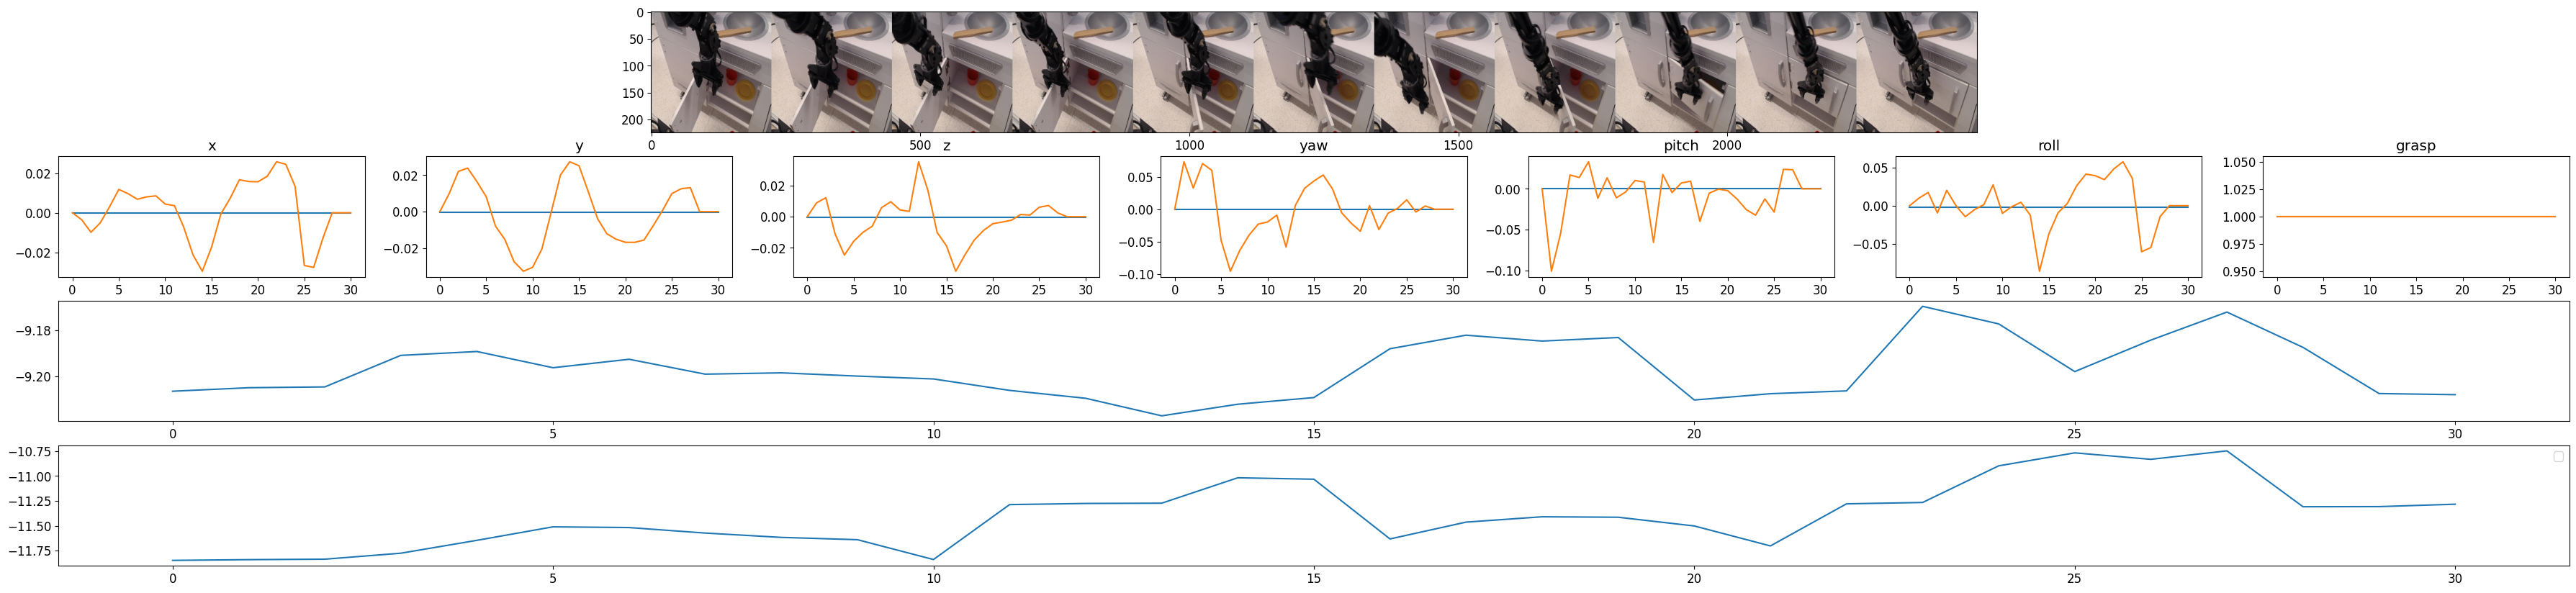

In [20]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS,
    ["value"] * len(ACTION_DIM_LABELS),
    ["value8"] * len(ACTION_DIM_LABELS),
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()

pred_values = np.array(pred_values).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

# plot value
axs['value'].plot(pred_values[..., -2])
axs['value8'].plot(pred_values[..., -1])

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()